In [1]:
import sys
sys.path.insert(0, '../tools')

%load_ext prov_magics
import mutable_prov
from qmutable_prov import *

In [2]:
querier.load("../mutable_prov/floydwarshall.provn");

In [3]:
from collections import namedtuple
from copy import copy
Context = namedtuple("Context", "type node moment")

def neighborhood(context):
    type_, n, t0 = context
    if type_ == "entity":
        # yield* Context(D,0) from wasDerivedFrom(N,D)
        d, dtext, otext = var(3)
        for _ in was_derived_from(n, d, text=dtext) & entity(d, otext):
            yield Context("entity", d.bound, None), {dtext.bound, otext.bound}
        
        # yield? Context(V,T) from accessed(N,V,T)
        v, t, atext, vtext = var(4)
        for _ in accessed(n, v, t, atext) &  value(v, vtext):
            yield Context("value", v.bound, t.bound), {atext.bound, vtext.bound}
            
        # yield? Context(V,T) from defined(N,V,T), T != T0
        v, t, atext, vtext = var(4)
        for _ in defined(n, v, t, atext) &  value(v, vtext):
            if t.bound != t0:
                yield Context("value", v.bound, t.bound), {atext.bound, vtext.bound}
            
        # if match accessedPart(N,W,K,P,T)
        w, k, p, t, aptext, vtext, wtext = var(7)
        for _ in accessed_part(n, w, k, p, t, aptext) &  value(p, vtext) &  value(w, wtext):
            # yield Context(P,T)
            yield Context("value", p.bound, t.bound), {aptext.bound, vtext.bound}
            
            # yield? Context(E,0) from derivedByInsertion(E,W,{(K,P)},-)
            e, changes, t2, dtext, etext = var(5)
            for _ in derived_by_insertion(e, w, changes, t2, dtext) & entity(e, etext):
                if (k.bound, p.bound) in changes.bound:
                    yield Context("entity", e.bound, None), {dtext.bound, etext.bound}
            
    if type_ == "value":
        # Sort derivedByInsertion(E,N,{(K,P)},T) and
        #   derivedByRemoval(-,N,-,T) by T
        parts = []
        e, changes, t2, dtext, etext = var(5)
        for _ in derived_by_insertion(e, n, changes, t2, dtext) & entity(e, etext):
            if t2.bound <= t0.bound:
                parts.append((t2.bound, e.bound, changes.bound, dtext.bound, etext.bound))
        parts.sort()
        # Reconstruct state to find valid keys at T <= T0
        state = {}
        for t2, e, changes, dtext, etext in parts:
            for key, part in changes:
                state[key] = (part, e, dtext, etext)
        # for each part P of value N valid at T0
        for key, (part, e, dtext, etext) in state.items():
            tresult = {dtext.bound}
            # yield Context(P, T0)
            vtext = var(1)
            for _ in value(part, vtext):
                tresult.add(vtext.bound)
            yield Context("value", part, t0), tresult
            # yield Context(E, 0)
            yield Context("entity", e, None), {etext}
        
        # yield? Context(E,T2) from wasDefinedBy(N,E,T2)
        e, atext, t2, etext = var(4)
        for _ in was_defined_by(n, e, t2, atext) &  entity(e, etext):
            yield Context("entity", e.bound, t2.bound), {atext.bound, etext.bound}
            
            
def dfs(ent, neigh):
    ent = "result_a020"
    context = Context("entity", ent, moment=None)
    stack = [context]
    visited = set()
    text = var("text")
    result = {text.bound for _ in entity(ent, text)} 

    while stack:
        context = stack.pop()
        for other, tresult in neigh(context):
            if other not in visited:
                visited.add(other)
                result |= tresult
                stack.append(other)
    return result



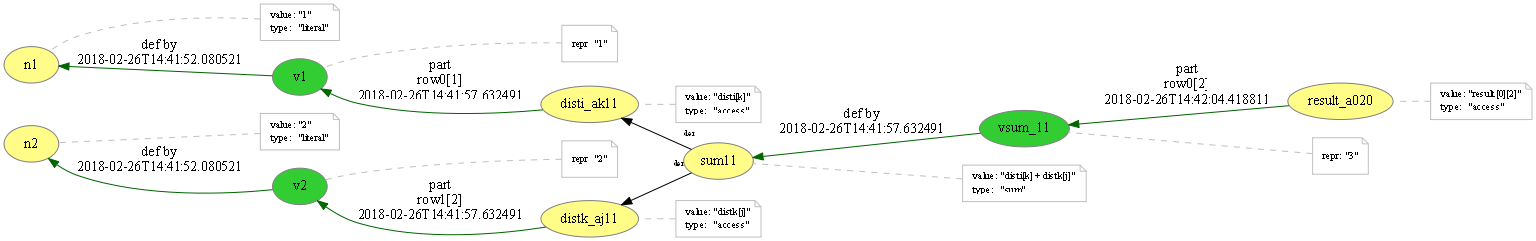

In [4]:
view = "provn png svg pdf"
get_ipython().run_cell_magic(
    "provn",
    "-o {} -e {} -r RL".format("../mutable_prov/query", view),
    '\n'.join(dfs("result_a020", neighborhood))
)

In [5]:
x = set()


In [6]:
x.add?